# Overview

This notebook is for fitting PCA model on the general German population data to reduce the dimension of the data and understand what the important components mean. We will apply the fitted PCA model to the customers data.

# Load data and packages

In [93]:
# import libraries here; add more as necessary
import os
import datetime
import re
import pickle 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
pd.set_option('max_colwidth', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('max_rows', 400)

# magic word for producing visualizations in notebook
%matplotlib inline

In [12]:
data = pd.read_csv("azdias_checkpoint_0307.csv").set_index("LNR")

In [3]:
attribute_values = pd.read_csv("attribute_values_cleaned_checkpoint.csv")

In [81]:
customers = pd.read_csv("customers_transformed_0308.csv")

In [4]:
attribute_descriptions = attribute_values[attribute_values['Description'].notna()][['Attribute','Description']]\
                         .groupby('Attribute').first().reset_index()
attribute_descriptions['Attribute1'] = attribute_descriptions['Attribute']\
                                       .apply(lambda x: "_".join(x.split("_")[:-1]))
attribute_descriptions['Attribute2'] = attribute_descriptions['Attribute']\
                                       .apply(lambda x: x.split("_")[0])

In [5]:
def attribute_to_descriptions(x):
    
    """
    Create a helper dataframe to help translate column names of azdias to the actual meanings so that it's 
    easier for us to understand the meanings of the components later
    """
    
    try:
        
        if x in list(attribute_descriptions['Attribute']):
            result = attribute_descriptions[attribute_descriptions['Attribute'] == x]['Description'].values[0]
        
        elif "_".join(x.split("_")[:-1]) in list(attribute_descriptions['Attribute']):
            y = "_".join(x.split("_")[:-1])
            result = attribute_descriptions[attribute_descriptions['Attribute'] == y]['Description'].values[0]
        
        elif x in list(attribute_descriptions['Attribute1']):
            result = attribute_descriptions[attribute_descriptions['Attribute1'] == x]['Description'].values[0]
                       
        elif "_".join(x.split("_")[:-1]) in list(attribute_descriptions['Attribute1']):
            z = "_".join(x.split("_")[:-1])
            result = attribute_descriptions[attribute_descriptions['Attribute1'] == z]['Description'].values[0]
        
        elif "_".join(x.split("_")[:-2]) in list(attribute_descriptions['Attribute1']):
            w = "_".join(x.split("_")[:-2])
            result = attribute_descriptions[attribute_descriptions['Attribute1'] == w]['Description'].values[0]
       
        elif x.split("_")[0] in list(attribute_descriptions['Attribute2']):
            u = x.split("_")[0]
            result = attribute_descriptions[attribute_descriptions['Attribute2'] == u]['Description'].values[0]
        
        return result
    
    except:

        return x

# Perform Dimensionality Reduction (PCA) on German general population data

In [113]:
pca = PCA(100)

In [114]:
general_pca = pca.fit_transform(data)

In [106]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

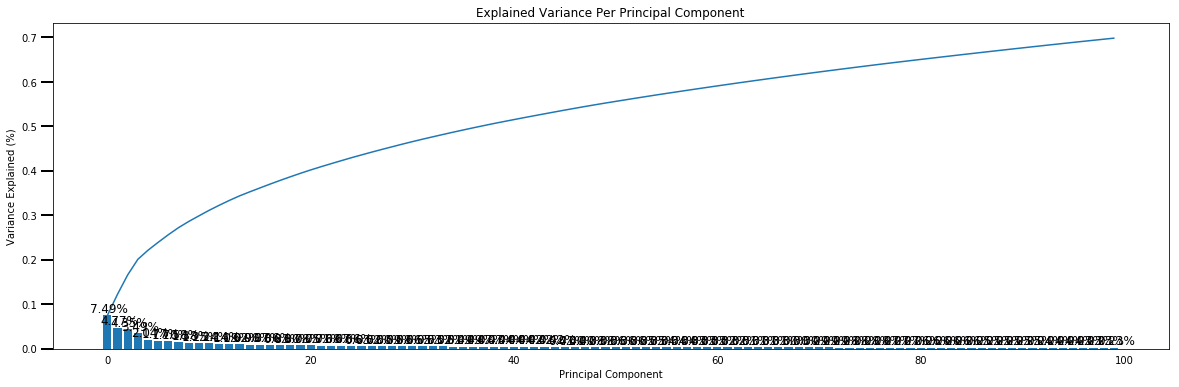

In [115]:
scree_plot(pca)

In [15]:
# Investigate the variance accounted for by each principal component.
sum(pca.explained_variance_ratio_)

0.6982385273555503

The first 100 components can explain 70% of the variance.

In [16]:
pca_components = pd.DataFrame(pca.components_, columns=data.columns)

In [17]:
pca_components.columns = [attribute_to_descriptions(i) for i in list(pca_components.columns)]

In [18]:
def display_important_features_for_pc(index):
    return pd.concat([pca_components.loc[index,:].sort_values(ascending=False).head(3),
                      pca_components.loc[index,:].sort_values(ascending=False).tail(3)])

# Explain the components

### First component

Low mobility, 1-2 family houses in the PLZ8, low share of AUDI within the PLZ8.

In [108]:
display_important_features_for_pc(0)

moving patterns                                         0.133800
number of 1-2 family houses in the PLZ8                 0.128520
share of AUDI within the PLZ8                           0.128020
CAMEO classification 2015 - detailled classification   -0.124806
share of AUDI within the PLZ8                          -0.127276
number of 6-10 family houses in the PLZ8               -0.127580
Name: 0, dtype: float64

### Second component

High online affinity and high recent transaction activity

In [109]:
display_important_features_for_pc(1)

online affinity                                                        0.145429
transaction activity TOTAL POOL in the last 24 months                  0.140497
transaction activity TOTAL POOL in the last 12 months                  0.132982
customer journey typology                                             -0.130357
actuality of the last transaction for the segment mail-order ONLINE   -0.131349
actuality of the last transaction with the complete file ONLINE       -0.136164
Name: 1, dtype: float64

### Third component

High share of BMW & Mercedes Benz, high share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.), low share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8, low share of cars with max speed between 140 and 210 km/h within the PLZ8, low numbers of cars with 5 seats in the PLZ8

In [110]:
display_important_features_for_pc(2)

share of BMW & Mercedes Benz within the PLZ8                                   0.178220
share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)    0.153275
share of MERCEDES within the PLZ8                                              0.151223
share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8    -0.126484
share of cars with max speed between 140 and 210 km/h within the PLZ8         -0.127418
number of cars with 5 seats in the PLZ8                                       -0.144333
Name: 2, dtype: float64

### Forth component

low "financial typology: be prepared", older age,  highly likely to be money saver or investor

In [111]:
display_important_features_for_pc(3)

financial typology: be prepared                 0.152177
age classification through prename analysis     0.141429
customer journey typology                       0.112580
financial typology: investor                   -0.163427
financial typology: unremarkable               -0.164740
financial typology: money saver                -0.168190
Name: 3, dtype: float64

# Extract important features

We will extract the top 2 features (that can be found explanations) for the top 20 components. We will use the output dataframe later.

In [212]:
#names of important features
im_features = []  
#meanings of important features
im_meanings = []
#original feature names
im_original_features = []
#component_list
com_list = []

pca_components_pd = pd.DataFrame(pca.components_, columns=data.columns)

for i in range(20):
    #get the list of the features ranked by values in the component
    c = list(pca_components_pd.iloc[i].sort_values(ascending=False).index)
    j = 0
    for f in c:
        d = attribute_to_descriptions(f)
        if d != f and j != 2:
            j += 1
            im_features.append(f)
            im_meanings.append(d)
            im_original_features.append(attribute_values[attribute_values['Description']==d]['Attribute'].values[0])
            com_list.append(i)
            
important_features_pd = pd.DataFrame({'feature' : im_features,
                                                         'description' : im_meanings,
                                                         'original_feature' : im_original_features,
                                                         'component' : com_list})

In [216]:
attribute_values_1 = attribute_values\
.groupby('Attribute')['value__meaning'].apply(list).reset_index()\
.merge(attribute_values[['Attribute','Description']][attribute_values['Description'].notna()], on="Attribute")

In [223]:
important_features_pd = important_features_pd\
.merge(attribute_values_1[['Attribute', 'value__meaning']].rename({'Attribute':'original_feature'}, axis=1), how="left")

In [228]:
important_features_pd.head()

,feature,description,original_feature,component,value__meaning
0,MOBI_REGIO,moving patterns,MOBI_REGIO,0,"[1__very high mobility, 2__high mobility, 3__middle mobility, 4__low mobility, 5__very low mobility , 6__none]"
1,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,PLZ8_ANTG1,0,"[-1__unknown, 0__none, 1__low share, 2__average share, 3__high share, 4__very high share]"
2,ONLINE_AFFINITAET,online affinity,ONLINE_AFFINITAET,1,"[0__none, 1__low, 2__middle, 3__high, 4__very high, 5__highest ]"
3,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24 months,D19_GESAMT_ANZ_24,1,"[0__no transactions known, 1__very low activity, 2__low activity, 3__slightly increased activity, 4__increased activity, 5__high activity, 6__very high activity]"
4,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,KBA13_HERST_BMW_BENZ,2,"[-1__unknown, 0__none, 1__very low, 2__low, 3__average, 4__high, 5__very high]"


# Perform the PCA transformation

In [80]:
pca = PCA(100).fit(data)

In [85]:
customers_pca = pca.transform(customers)

# Checkpoint

In [118]:
pd.DataFrame(pca.components_, columns=data.columns).to_csv("pca_components_0308.csv", index=False)

In [90]:
pd.DataFrame(general_pca).to_csv("general_pca_0308.csv", index=False)

In [91]:
pd.DataFrame(customers_pca).to_csv("customers_pca_0308.csv", index=False)

In [94]:
with open("pca.p", 'wb') as pickle_file:
    pickle.dump(pca, pickle_file)

In [174]:
with open("top_20_features.p", 'wb') as pickle_file:
    pickle.dump(top_20_features, pickle_file)

In [177]:
data[top_20_features].to_csv("general_important_features.csv", index=False)

In [179]:
customers[top_20_features].to_csv("customer_important_features.csv", index=False)

In [225]:
important_features_pd.to_csv("important_features.csv", index=False)